# Introduction

This weekend, I decided to perform a short test on the Group Relative Policy Optimization (GRPO) technique, introduced in **DeepSeekMath: Pushing the Limits of Mathematical Reasoning in Open Language Models.**

Specifically I would like to teach an open source LLM to reason in a non-English language, specifically **Italian**.

On HuggingFace there are several leaderboards regarding different LLMs (pretrained, fine-tuned, RL-tuned) and their performances in different languages. This one [here](https://huggingface.co/spaces/mii-llm/open_ita_llm_leaderboard) is the Italian one.

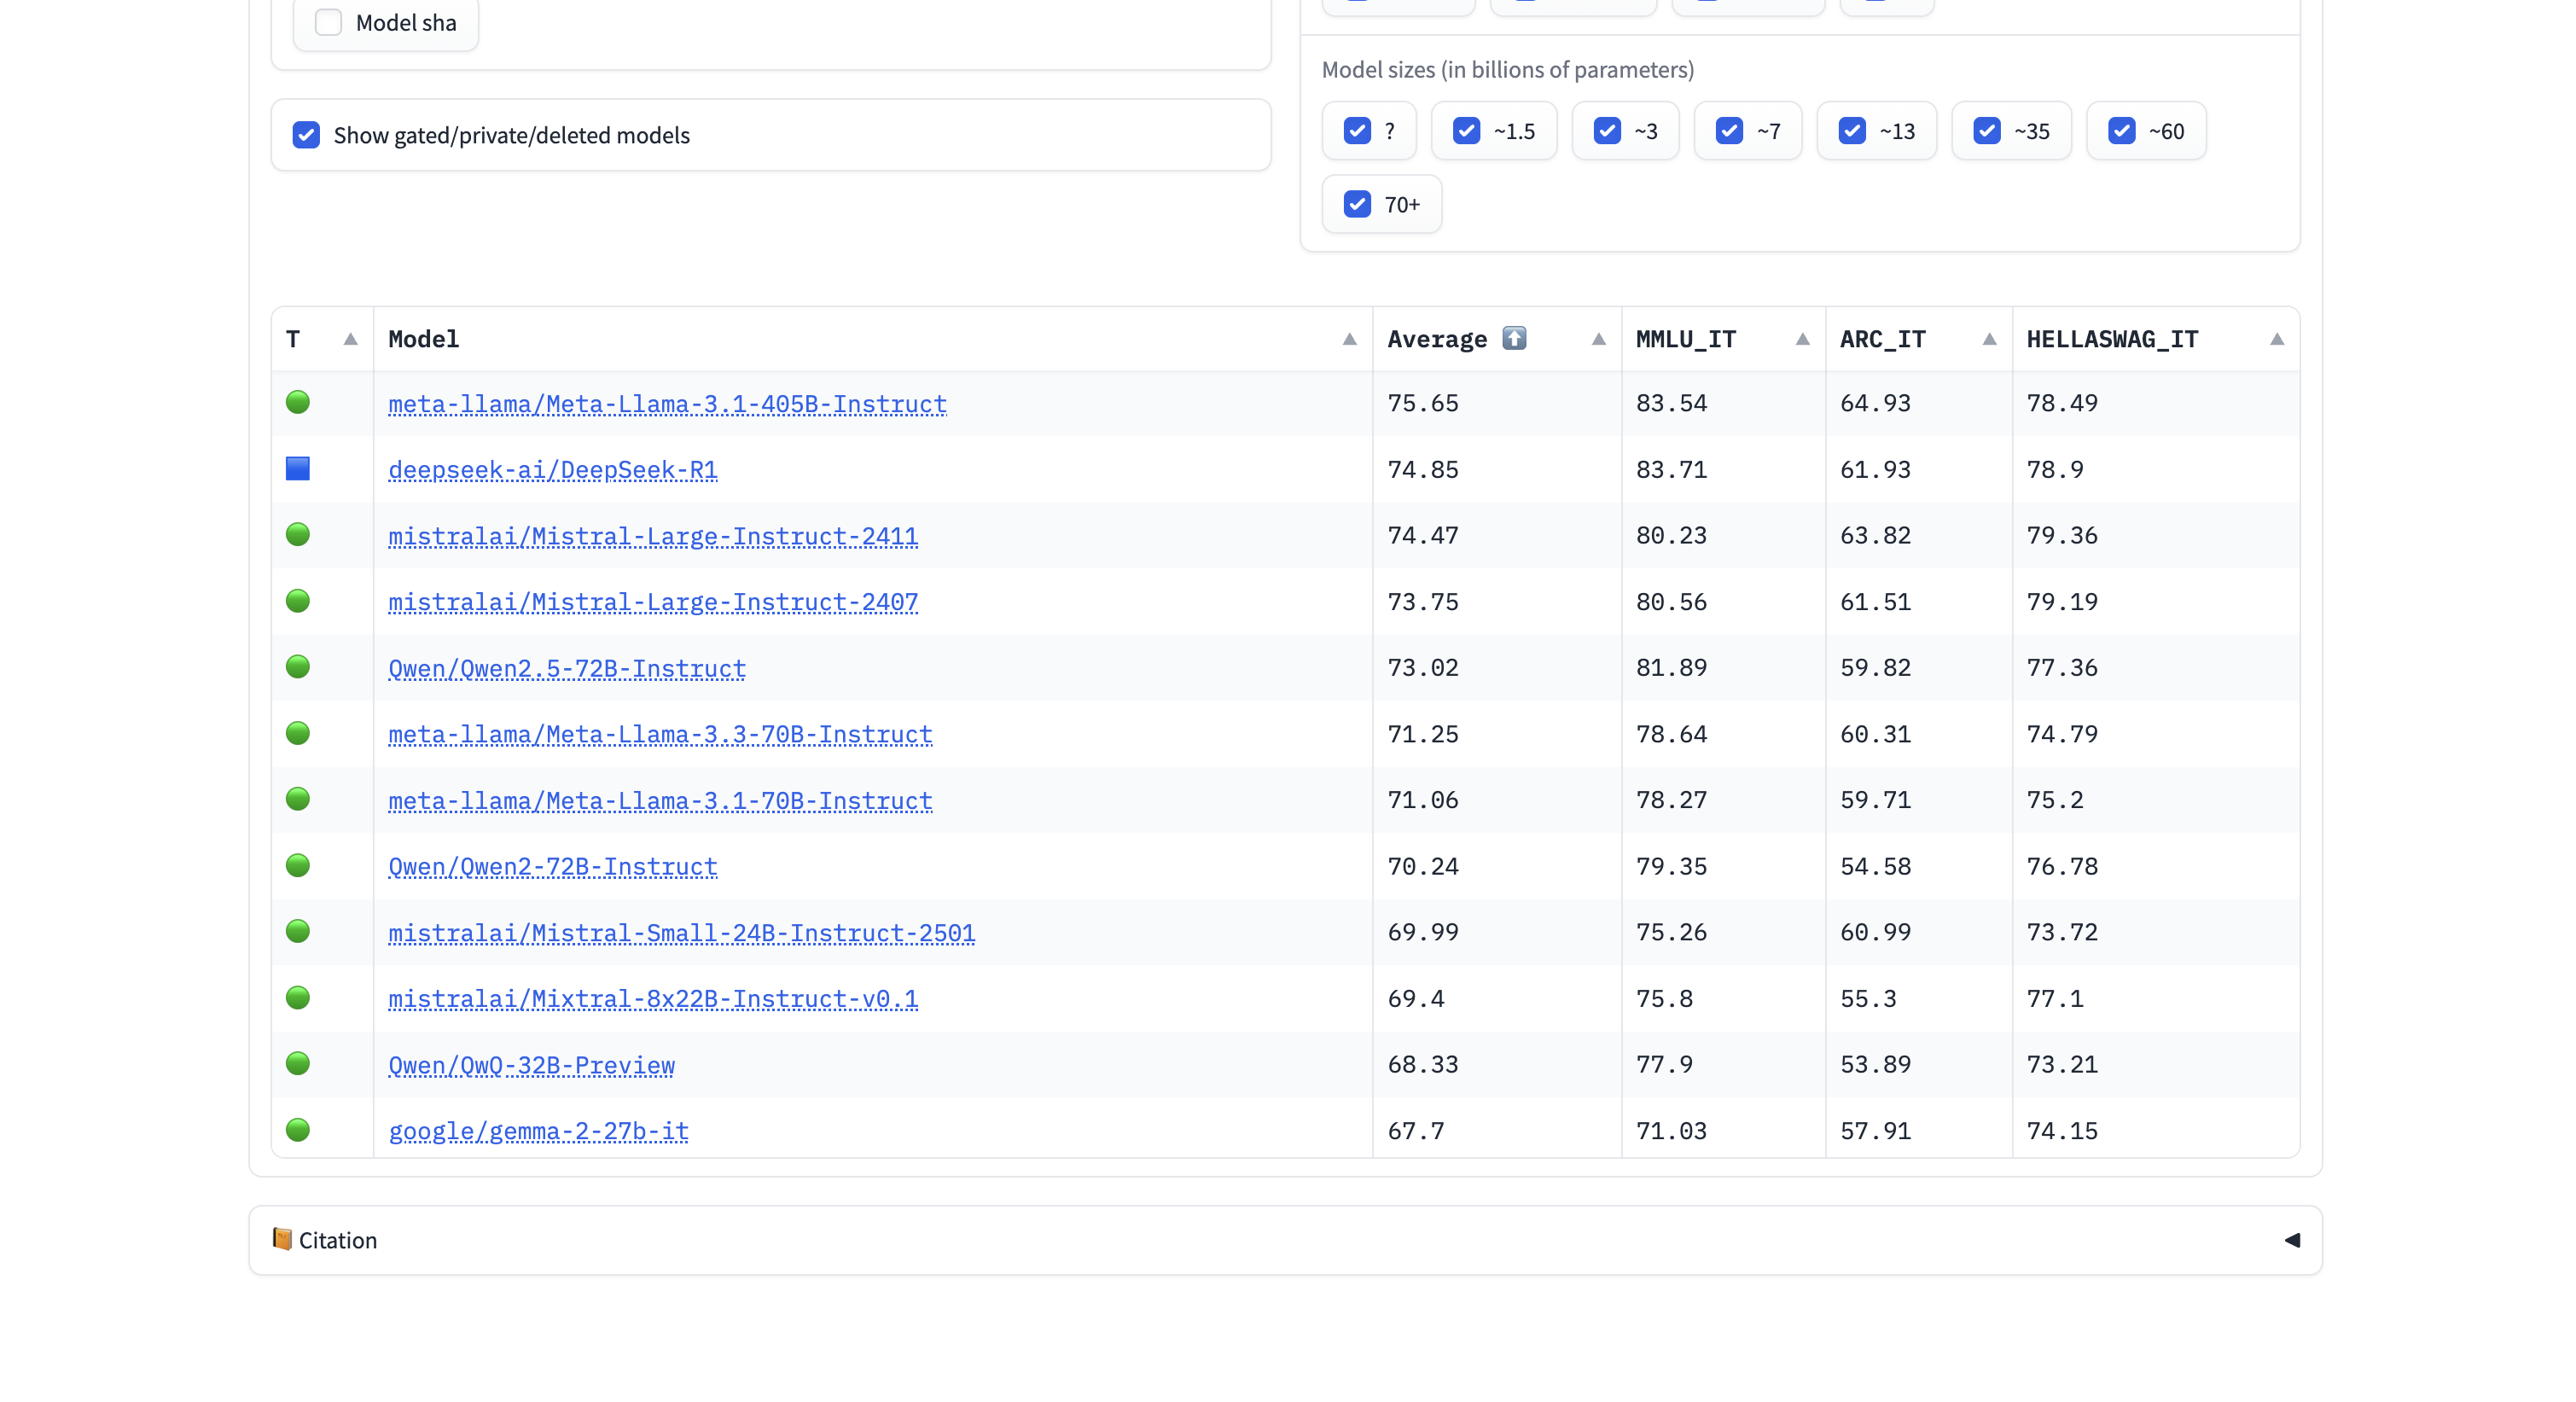


## Base Model

In [1]:
%%capture
import os
if "COLAB_" not in "".join(os.environ.keys()):
    !pip install unsloth
else:
    # Do this only in Colab notebooks! Otherwise use pip install unsloth
    !pip install --no-deps bitsandbytes accelerate xformers==0.0.29.post3 peft trl triton cut_cross_entropy unsloth_zoo
    !pip install sentencepiece protobuf "datasets>=3.4.1" huggingface_hub hf_transfer
    !pip install --no-deps unsloth

In [2]:
from unsloth import FastLanguageModel
import torch
max_seq_length = 2048 # Choose any! We auto support RoPE Scaling internally!
dtype = None # None for auto detection. Float16 for Tesla T4, V100, Bfloat16 for Ampere+
load_in_4bit = False # Use 4bit quantization to reduce memory usage. Can be False.

# 4bit pre quantized models we support for 4x faster downloading + no OOMs.
fourbit_models = [
    "unsloth/Meta-Llama-3.1-8B-bnb-4bit",      # Llama-3.1 15 trillion tokens model 2x faster!
    "unsloth/Meta-Llama-3.1-8B-Instruct-bnb-4bit",
    "unsloth/Meta-Llama-3.1-70B-bnb-4bit",
    "unsloth/Meta-Llama-3.1-405B-bnb-4bit",    # We also uploaded 4bit for 405b!
    "unsloth/Mistral-Nemo-Base-2407-bnb-4bit", # New Mistral 12b 2x faster!
    "unsloth/Mistral-Nemo-Instruct-2407-bnb-4bit",
    "unsloth/mistral-7b-v0.3-bnb-4bit",        # Mistral v3 2x faster!
    "unsloth/mistral-7b-instruct-v0.3-bnb-4bit",
    "unsloth/Phi-3.5-mini-instruct",           # Phi-3.5 2x faster!
    "unsloth/Phi-3-medium-4k-instruct",
    "unsloth/gemma-2-9b-bnb-4bit",
    "unsloth/gemma-2-27b-bnb-4bit",            # Gemma 2x faster!
] # More models at https://huggingface.co/unsloth

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = "unsloth/Meta-Llama-3.1-8B",
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    # token = "hf_...", # use one if using gated models like meta-llama/Llama-2-7b-hf
)

🦥 Unsloth: Will patch your computer to enable 2x faster free finetuning.
🦥 Unsloth Zoo will now patch everything to make training faster!
==((====))==  Unsloth 2025.7.2: Fast Llama patching. Transformers: 4.53.1.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = 0.0.29.post3. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/235 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/459 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

In [3]:
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""

In [4]:
# alpaca_prompt = Copied from above
FastLanguageModel.for_inference(model) # Enable native 2x faster inference
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Continue the fibonnaci sequence.", # instruction
        "1, 1, 2, 3, 5, 8", # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
tokenizer.batch_decode(outputs)

['<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nContinue the fibonnaci sequence.\n\n### Input:\n1, 1, 2, 3, 5, 8\n\n### Response:\n13, 21, 34, 55, 89, 144\n\n### Explanation:\nThe fibonnaci sequence is the sequence of numbers where each number is the sum of the two preceding numbers. For example, 1 + 1 = 2, 2 + 3 = 5, ']

## Datasets: [ARC-IT](https://huggingface.co/datasets/s-conia/arc_italian/viewer/arc_challenge/train?row=0&views%5B%5D=arc_challenge_train).

### Download it

In [5]:
from datasets import load_dataset
dataset = load_dataset("s-conia/arc_italian", 'arc_challenge', split = "train")

README.md: 0.00B [00:00, ?B/s]

arc_challenge.train.jsonl: 0.00B [00:00, ?B/s]

arc_challenge.validation.jsonl: 0.00B [00:00, ?B/s]

arc_challenge.test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/1119 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/299 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1172 [00:00<?, ? examples/s]

### Convert to a Dataframe

In [6]:
import pandas as pd

df = pd.DataFrame(dataset)
df.head()

,id,input,input_translation,label,metadata,choices,choices_translation
0,Mercury_SC_415702,George wants to warm his hands quickly by rubb...,George vuole scaldarsi rapidamente le mani str...,0,{'category': 'question'},"[Dry palms., Wet palms., Palms covered with oi...","[Palmi asciutti., Palmi bagnati., Palmi copert..."
1,MCAS_2009_5_6516,Which of the following statements best explain...,Quale delle seguenti affermazioni spiega megli...,1,{'category': 'question'},"[The refrigerator door is smooth., The refrige...","[La porta del frigorifero è liscia., La porta ..."
2,Mercury_7233695,A fold observed in layers of sedimentary rock ...,Una piega osservata negli strati di roccia sed...,1,{'category': 'text_completion'},"[cooling of flowing magma., converging of crus...","[raffreddamento del magma in movimento., conve..."
3,Mercury_7041615,Which of these do scientists offer as the most...,Quale di queste spiegazioni offrono gli scienz...,3,{'category': 'question'},"[Worldwide disease., Global mountain building....","[Malattia mondiale., Costruzione globale di mo..."
4,Mercury_7041860,A boat is acted on by a river current flowing ...,Una barca è influenzata da una corrente fluvia...,1,{'category': 'question'},"[West., East., North., South.]","[Ovest., Est., Nord., Sud.]"


In [7]:
type(df['choices_translation'][0])

list

### Test it

In [8]:
# Load and prep dataset
SYSTEM_PROMPT = """
Respond in the following format:
<reasoning>
...
</reasoning>
<answer>
...
</answer>
"""
alpaca_prompt = """Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.

### Instruction:
{}

### Input:
{}

### Response:
{}"""



In [9]:
test=df['choices_translation'][0]
type(test)

list

In [10]:
dict(enumerate(df['choices_translation'][0]))

{0: 'Palmi asciutti.',
 1: 'Palmi bagnati.',
 2: 'Palmi coperti di olio.',
 3: 'Palmi coperti di crema.'}

In [ ]:
def convert_list_choices(choices: list) -> str:


In [12]:
inputs = tokenizer(
[
    alpaca_prompt.format(
        "Given a multiple-answer question to whose choices are assigned numbers, answer using only the number.",
        "Here the question: "+ df['input_translation'][0] + " Choices: " + str(dict(enumerate(df['choices_translation'][0]))), # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
result=tokenizer.batch_decode(outputs)

In [13]:
result[0]

"<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nGiven a multiple-answer question to whose choices are assigned numbers, answer using only the number.\n\n### Input:\nHere the question: George vuole scaldarsi rapidamente le mani strofinandole. Quale superficie della pelle produrrà più calore? Choices: {0: 'Palmi asciutti.', 1: 'Palmi bagnati.', 2: 'Palmi coperti di olio.', 3: 'Palmi coperti di crema.'}\n\n### Response:\n1\n\n### Explanation:\nThe palmi bagnati choice will produce the most heat because the water will conduct the heat more easily.<|end_of_text|>"

In [14]:
import re
def extract_label(result: list)->str:
  match = re.search(r'### Response:\n(\d+)', result[0])
  if match:
    response_number = int(match.group(1))
    return response_number
  else:
    return "No response number found."

In [15]:
extract_label(result)

1

In [16]:
result[0].split("#### Response")[0].strip()

"<|begin_of_text|>Below is an instruction that describes a task, paired with an input that provides further context. Write a response that appropriately completes the request.\n\n### Instruction:\nGiven a multiple-answer question to whose choices are assigned numbers, answer using only the number.\n\n### Input:\nHere the question: George vuole scaldarsi rapidamente le mani strofinandole. Quale superficie della pelle produrrà più calore? Choices: {0: 'Palmi asciutti.', 1: 'Palmi bagnati.', 2: 'Palmi coperti di olio.', 3: 'Palmi coperti di crema.'}\n\n### Response:\n1\n\n### Explanation:\nThe palmi bagnati choice will produce the most heat because the water will conduct the heat more easily.<|end_of_text|>"

### Evaluate the model

In [17]:
response_llm = []
full_response_llm = []
response_correct=[]
input=[]
choices=[]
correct=[]


for index, row in df.iterrows():
  input.append(row['input_translation'])
  choices.append(str(dict(enumerate(row['choices_translation']))))
  response_correct.append(str(row['label']))
  inputs = tokenizer(
[
    alpaca_prompt.format(
        "Given a multiple-answer question whose choices are in key-pair format, return only the number of choice",
        "Here the question: "+ row['input_translation'] + " Choices: " + str(dict(enumerate(row['choices_translation']))), # input
        "", # output - leave this blank for generation!
    )
], return_tensors = "pt").to("cuda")

  outputs = model.generate(**inputs, max_new_tokens = 64, use_cache = True)
  result=tokenizer.batch_decode(outputs)
  full_response_llm.append(tokenizer.batch_decode(outputs))
  print("LLM: ", extract_label(result))
  response_llm.append(extract_label(result))
  print("Correct: ", row['label']==extract_label(result))
  correct.append(row['label']==extract_label(result))

# dictionary of lists
dict = {'Question': input, 'Choices': choices, 'ground_truth': response_correct, 'Response_Llama': response_llm, 'Match': correct, "Full_response": full_response_llm}

df = pd.DataFrame(dict)



LLM:  3
Correct:  False
LLM:  3
Correct:  False
LLM:  3
Correct:  False
LLM:  3
Correct:  True
LLM:  3
Correct:  False
LLM:  2
Correct:  False
LLM:  2
Correct:  True
LLM:  2
Correct:  False
LLM:  3
Correct:  False
LLM:  2
Correct:  True
LLM:  2
Correct:  False
LLM:  3
Correct:  False
LLM:  3
Correct:  False
LLM:  3
Correct:  False
LLM:  2
Correct:  False
LLM:  3
Correct:  False
LLM:  3
Correct:  False
LLM:  3
Correct:  True
LLM:  3
Correct:  False
LLM:  3
Correct:  False
LLM:  3
Correct:  False
LLM:  3
Correct:  False
LLM:  2
Correct:  False
LLM:  2
Correct:  False
LLM:  No response number found.
Correct:  False
LLM:  No response number found.
Correct:  False
LLM:  3
Correct:  False
LLM:  2
Correct:  False
LLM:  3
Correct:  False
LLM:  2
Correct:  True
LLM:  3
Correct:  False
LLM:  3
Correct:  True
LLM:  No response number found.
Correct:  False
LLM:  3
Correct:  False
LLM:  2
Correct:  False
LLM:  1
Correct:  False
LLM:  3
Correct:  False
LLM:  2
Correct:  False
LLM:  No response numb

In [18]:
df

,Question,Choices,ground_truth,Response_Llama,Match,Full_response
0,George vuole scaldarsi rapidamente le mani str...,"{0: 'Palmi asciutti.', 1: 'Palmi bagnati.', 2:...",0,3,False,[<|begin_of_text|>Below is an instruction that...
1,Quale delle seguenti affermazioni spiega megli...,"{0: 'La porta del frigorifero è liscia.', 1: '...",1,3,False,[<|begin_of_text|>Below is an instruction that...
2,Una piega osservata negli strati di roccia sed...,"{0: 'raffreddamento del magma in movimento.', ...",1,3,False,[<|begin_of_text|>Below is an instruction that...
3,Quale di queste spiegazioni offrono gli scienz...,"{0: 'Malattia mondiale.', 1: 'Costruzione glob...",3,3,True,[<|begin_of_text|>Below is an instruction that...
4,Una barca è influenzata da una corrente fluvia...,"{0: 'Ovest.', 1: 'Est.', 2: 'Nord.', 3: 'Sud.'}",1,3,False,[<|begin_of_text|>Below is an instruction that...
...,...,...,...,...,...,...
1114,Quale cambiamento aumenterebbe più probabilmen...,"{0: 'Inondazione.', 1: 'Siccità.', 2: 'Incendi...",0,3,False,[<|begin_of_text|>Below is an instruction that...
1115,La pelle è l'organo più grande del corpo umano...,"{0: 'È composta da cellule.', 1: 'Agisce come ...",2,3,False,[<|begin_of_text|>Below is an instruction that...
1116,Quale cibo fornisce più energia per il corpo n...,"{0: 'Patata.', 1: 'Carne.', 2: 'Latte.', 3: 'F...",3,2,False,[<|begin_of_text|>Below is an instruction that...
1117,Le civette screech hanno due variazioni di col...,"{0: 'Nidificazione.', 1: 'Nutrimento.', 2: 'Ri...",3,3,True,[<|begin_of_text|>Below is an instruction that...


In [19]:
cleaned_df= df[df['Response_Llama'] != "No response number found."]

In [20]:
cleaned_df

,Question,Choices,ground_truth,Response_Llama,Match,Full_response
0,George vuole scaldarsi rapidamente le mani str...,"{0: 'Palmi asciutti.', 1: 'Palmi bagnati.', 2:...",0,3,False,[<|begin_of_text|>Below is an instruction that...
1,Quale delle seguenti affermazioni spiega megli...,"{0: 'La porta del frigorifero è liscia.', 1: '...",1,3,False,[<|begin_of_text|>Below is an instruction that...
2,Una piega osservata negli strati di roccia sed...,"{0: 'raffreddamento del magma in movimento.', ...",1,3,False,[<|begin_of_text|>Below is an instruction that...
3,Quale di queste spiegazioni offrono gli scienz...,"{0: 'Malattia mondiale.', 1: 'Costruzione glob...",3,3,True,[<|begin_of_text|>Below is an instruction that...
4,Una barca è influenzata da una corrente fluvia...,"{0: 'Ovest.', 1: 'Est.', 2: 'Nord.', 3: 'Sud.'}",1,3,False,[<|begin_of_text|>Below is an instruction that...
...,...,...,...,...,...,...
1114,Quale cambiamento aumenterebbe più probabilmen...,"{0: 'Inondazione.', 1: 'Siccità.', 2: 'Incendi...",0,3,False,[<|begin_of_text|>Below is an instruction that...
1115,La pelle è l'organo più grande del corpo umano...,"{0: 'È composta da cellule.', 1: 'Agisce come ...",2,3,False,[<|begin_of_text|>Below is an instruction that...
1116,Quale cibo fornisce più energia per il corpo n...,"{0: 'Patata.', 1: 'Carne.', 2: 'Latte.', 3: 'F...",3,2,False,[<|begin_of_text|>Below is an instruction that...
1117,Le civette screech hanno due variazioni di col...,"{0: 'Nidificazione.', 1: 'Nutrimento.', 2: 'Ri...",3,3,True,[<|begin_of_text|>Below is an instruction that...


### Accuracy

We calculate now the **accuracy** of the cleaned responses, where `accuracy = correct_predictions / total_questions`


In [24]:
count_A = (cleaned_df['Match'] == True).sum()
accuracy=count_A/len(cleaned_df)
print("Accuracy: ", accuracy*100)

Accuracy:  27.906976744186046


In this case, the Accuracy is approximately **28%** for this LLM. We will try out to improve by using RL post-training

In [25]:
cleaned_df.to_csv('eval_llama_31_arc_it.csv')

# Data Preparation

For the training dataset we will use `s-conia/gsm8k_italian` which you can find [here](https://huggingface.co/datasets/s-conia/gsm8k_italian/viewer/default/train?p=7). We will not use all the samples but only a very small part (about **1k**) and we will have to make some modifications to prepare it for training. There are some limitations. First of all, the quality of the translations from English. Also, the examples are oriented to mathematical problems.

#### Download GSM8k

In [26]:
dataset = load_dataset("s-conia/gsm8k_italian", split = "test")

README.md: 0.00B [00:00, ?B/s]

gsm8k.train.jsonl: 0.00B [00:00, ?B/s]

gsm8k.test.jsonl: 0.00B [00:00, ?B/s]

Generating train split:   0%|          | 0/7473 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1319 [00:00<?, ? examples/s]

In [27]:
train_df = pd.DataFrame(dataset)
train_df.head()

,id,input,input_translation,label,metadata
0,test-00000,Janet’s ducks lay 16 eggs per day. She eats th...,Le anatre di Janet depongono 16 uova al giorno...,18,"{'category': 'question', 'distractors': ['16',..."
1,test-00001,A robe takes 2 bolts of blue fiber and half th...,Una veste richiede 2 rotoli di fibra blu e met...,3,"{'category': 'question', 'distractors': ['1', ..."
2,test-00002,Josh decides to try flipping a house. He buys ...,Josh decide di provare a rivendere una casa. C...,70000,"{'category': 'question', 'distractors': ['6999..."
3,test-00003,James decides to run 3 sprints 3 times a week....,James decide di fare 3 sprint 3 volte a settim...,540,"{'category': 'question', 'distractors': ['538'..."
4,test-00004,"Every day, Wendi feeds each of her chickens th...","Ogni giorno, Wendi dà da mangiare a ciascuna d...",20,"{'category': 'question', 'distractors': ['18',..."


In [29]:
train_df['metadata'][0]['explanation_translation']

"Janet vende 16 - 3 - 4 = 9 uova d'anatra al giorno. Guadagna 9 * 2 = 18 dollari ogni giorno al mercato contadino."

In [34]:
question = []
answer = []
for index, row in train_df.iterrows():
  question.append(row['input_translation'])
  final_answer=row['metadata']['explanation_translation'] + " #### " + row['label']
  answer.append(final_answer)

# dictionary of lists
dict = {'question': question, 'answer': answer}

cleaned_train_df = pd.DataFrame(dict)

In [35]:
cleaned_train_df.head()

,question,answer
0,Le anatre di Janet depongono 16 uova al giorno...,Janet vende 16 - 3 - 4 = 9 uova d'anatra al gi...
1,Una veste richiede 2 rotoli di fibra blu e met...,Ci vogliono 2/2=1 rotolo di fibra bianca. Quin...
2,Josh decide di provare a rivendere una casa. C...,Il costo della casa e delle riparazioni è stat...
3,James decide di fare 3 sprint 3 volte a settim...,Fa sprint 3*3=9 volte. Quindi corre 9*60=540 m...
4,"Ogni giorno, Wendi dà da mangiare a ciascuna d...",Se ogni gallina mangia 3 tazze di mangime al g...


In [37]:
cleaned_train_df['answer'][0]

"Janet vende 16 - 3 - 4 = 9 uova d'anatra al giorno. Guadagna 9 * 2 = 18 dollari ogni giorno al mercato contadino. #### 18"

In [38]:
cleaned_train_df.to_csv('train_gsm8k_ita.csv')

#### Push the dataset to HuggingFace

In [39]:
from huggingface_hub import login
from google.colab import userdata

HF_TOKEN = userdata.get('HF_TOKEN')
if HF_TOKEN:
    login(HF_TOKEN)
    print("Successfully logged in to Hugging Face!")
else:
    print("Token is not set. Please save the token first.")


Successfully logged in to Hugging Face!


In [40]:
from datasets import Dataset
dataset = Dataset.from_pandas(cleaned_train_df)


In [41]:
dataset.push_to_hub("JacopoCirica/test_gsm8k_it_grpo", private=False) # Set private=True for a private dataset


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ? shards/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?it/s]

CommitInfo(commit_url='https://huggingface.co/datasets/JacopoCirica/test_gsm8k_it_grpo/commit/3a0d60ae173d9c3f6ac50af3d22e257e86566d14', commit_message='Upload dataset', commit_description='', oid='3a0d60ae173d9c3f6ac50af3d22e257e86566d14', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/JacopoCirica/test_gsm8k_it_grpo', endpoint='https://huggingface.co', repo_type='dataset', repo_id='JacopoCirica/test_gsm8k_it_grpo'), pr_revision=None, pr_num=None)